In [1]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
from numpy import array
from keras import regularizers
from math import sqrt
from matplotlib import pyplot
import matplotlib.pyplot as plt
import numpy as np
from numpy import concatenate
import random
import time


Using TensorFlow backend.


In [13]:

# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime(x, "'[%H:%M:%S %d/%m/%Y]'")

# convert time series into supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# transform series into train and test sets for supervised learning
def prepare_data(series, n_test, n_lag, n_seq):
	# extract raw values
	raw_values = series.values
	# transform data to be stationary
	diff_series = difference(raw_values, 1)
	diff_values = diff_series.values
	diff_values = diff_values.reshape(len(diff_values), 1)
	# rescale values to -1, 1
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaled_values = scaler.fit_transform(diff_values)
	scaled_values = scaled_values.reshape(len(scaled_values), 1)
	# transform into supervised learning problem X, y
	supervised = series_to_supervised(scaled_values, n_lag, n_seq)
	supervised_values = supervised.values
	# split into train and test sets
	train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
	return scaler, train, test

# fit an LSTM network to training data
def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
	# reshape training into [samples, timesteps, features]
	X, y = train[:, 0:n_lag], train[:, n_lag:]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	# design network
	model = Sequential()
	model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(y.shape[1]))
	model.compile(loss='mean_squared_error', optimizer='adam')
	# fit network
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)
		model.reset_states()
	return model

# make one forecast with an LSTM,
def forecast_lstm(model, X, n_batch):
	# reshape input pattern to [samples, timesteps, features]
	X = X.reshape(1, 1, len(X))
	# make forecast
	forecast = model.predict(X, batch_size=n_batch)
	# convert to array
	return [x for x in forecast[0, :]]

# evaluate the persistence model
def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
	forecasts = list()
	for i in range(len(test)):
		X, y = test[i, 0:n_lag], test[i, n_lag:]
		# make forecast
		forecast = forecast_lstm(model, X, n_batch)
		# store the forecast
		forecasts.append(forecast)
	return forecasts

# invert differenced forecast
def inverse_difference(last_ob, forecast):
	# invert first forecast
	inverted = list()
	inverted.append(forecast[0] + last_ob)
	# propagate difference forecast using inverted first value
	for i in range(1, len(forecast)):
		inverted.append(forecast[i] + inverted[i-1])
	return inverted

# inverse data transform on forecasts
def inverse_transform(series, forecasts, scaler, n_test):
	inverted = list()
	for i in range(len(forecasts)):
		# create array from forecast
		forecast = array(forecasts[i])
		forecast = forecast.reshape(1, len(forecast))
		# invert scaling
		inv_scale = scaler.inverse_transform(forecast)
		inv_scale = inv_scale[0, :]
		# invert differencing
		index = len(series) - n_test + i - 1
		last_ob = series.values[index]
		inv_diff = inverse_difference(last_ob, inv_scale)
		# store
		inverted.append(inv_diff)
	return inverted

# evaluate the RMSE for each forecast time step

def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    totalRMSE=list()
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual, predicted))
        totalRMSE.append(rmse)
        print('t+%d RMSE: %f' % ((i+1), rmse))
    print("Avrage RMSE",np.mean(totalRMSE)) 

# plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, n_test):
	# plot the entire dataset in blue
	pyplot.plot(series.values)
	# plot the forecasts in red
	for i in range(len(forecasts)):
		off_s = len(series) - n_test + i - 1
		off_e = off_s + len(forecasts[i]) + 1
		xaxis = [x for x in range(off_s, off_e)]
		yaxis = [series.values[off_s]] + forecasts[i]
		pyplot.plot(xaxis, yaxis, color='red')
	# show the plot
	pyplot.show()

# load dataset
series = read_csv('samples(3).csv', header=1,parse_dates=[0],index_col=0, squeeze=True,date_parser=parser)	

# configure


In [4]:
n_lag = 6
n_seq = 5
n_test = 420
n_epochs = 10
n_batch = 1
n_neurons = 50
# extract raw values
raw_values = series.values
# transform data to be stationary
diff_series = difference(raw_values, 1)
diff_values = diff_series.values
diff_values = diff_values.reshape(len(diff_values), 1)
# rescale values to -1, 1
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_values = scaler.fit_transform(diff_values)
scaled_values = scaled_values.reshape(len(scaled_values), 1)
# transform into supervised learning problem X, y
supervised = series_to_supervised(scaled_values, n_lag, n_seq)
supervised_values = supervised.values
# split into train and test sets
train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
X_train, y_train = train[:, 0:n_lag], train[:, n_lag:]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])



In [5]:
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch


def build_model(hp):
    num_units_min  =  10
    num_units_max  =  150
    num_units_step =  10

    dropout_min  =  .2
    dropout_max  =  0.5
    dropout_step =  0.1
    
    model = keras.Sequential()
    model.add(layers.LSTM(units=hp.Int('unit1',  min_value=num_units_min,
                                                 max_value=num_units_max,
                                                 step=num_units_step),
                                                 activation='relu',
                                                 input_shape=(X_train.shape[1], X_train.shape[2]), 
                                                 kernel_initializer='normal', 
                                                 kernel_regularizer=keras.regularizers.l2(hp.Choice('reg_rate',values=[0.01, 0.05, 0.1])),
                        
                                                 return_sequences = False))
    model.add(layers.Dropout(hp.Float('dropout_1',min_value=dropout_min,
                                      max_value=dropout_max,
                                      step=dropout_step) ) )


    model.add(layers.Dense(n_seq))
    model.compile(
        optimizer='adam',
        loss='mean_squared_error',
        metrics=['mean_squared_error', 'mean_absolute_error'])
    return model


In [7]:
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
from tensorflow.keras.callbacks import EarlyStopping

tuner = RandomSearch(
    build_model,
    objective='mean_squared_error',
    max_trials=2,
  
    project_name='LSTMonelayer')

In [8]:

early_stopping = EarlyStopping(monitor='mean_squared_error', patience=10, verbose=1)
callback_list = [ early_stopping ]

# split training data into stratified train/dev sets

tuner.search(X_train, y_train,
             epochs=10,
             batch_size=1, 
             callbacks=callback_list)
model = tuner.get_best_models(num_models=1)[0]

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 1275 samples
Epoch 1/10
1164/1275 [==========================>...] - ETA: 24:44 - loss: 0.1092 - mean_squared_error: 0.0189 - mean_absolute_error: 0.131 - ETA: 2:08 - loss: 0.1015 - mean_squared_error: 0.0254 - mean_absolute_error: 0.119 - ETA: 1:12 - loss: 0.0901 - mean_squared_error: 0.0245 - mean_absolute_error: 0.11 - ETA: 51s - loss: 0.0927 - mean_squared_error: 0.0356 - mean_absolute_error: 0.1298 - ETA: 41s - loss: 0.0834 - mean_squared_error: 0.0328 - mean_absolute_error: 0.128 - ETA: 32s - loss: 0.0749 - mean_squared_error: 0.0312 - mean_absolute_error: 0.124 - ETA: 27s - loss: 0.0757 - mean_squared_error: 0.0375 - mean_absolute_error: 0.131 - ETA: 24s - loss: 0.0704 - mean_squared_error: 0.0361 - mean_absolute_error: 0.130 - ETA: 21s - loss: 0.0712 - mean_squared_error: 0.0407 - mean_absolute_error: 0.137 - ETA: 19s - loss: 0.0707 - mean_squared_error: 0.0432 - mean_absolute

 969/1275 [=====================>........] - ETA: 8s - loss: 0.0078 - mean_squared_error: 0.0078 - mean_absolute_error: 0.07 - ETA: 6s - loss: 0.0234 - mean_squared_error: 0.0233 - mean_absolute_error: 0.09 - ETA: 5s - loss: 0.0302 - mean_squared_error: 0.0302 - mean_absolute_error: 0.11 - ETA: 5s - loss: 0.0295 - mean_squared_error: 0.0295 - mean_absolute_error: 0.10 - ETA: 5s - loss: 0.0309 - mean_squared_error: 0.0309 - mean_absolute_error: 0.11 - ETA: 5s - loss: 0.0320 - mean_squared_error: 0.0320 - mean_absolute_error: 0.11 - ETA: 5s - loss: 0.0340 - mean_squared_error: 0.0339 - mean_absolute_error: 0.11 - ETA: 5s - loss: 0.0318 - mean_squared_error: 0.0318 - mean_absolute_error: 0.11 - ETA: 5s - loss: 0.0355 - mean_squared_error: 0.0355 - mean_absolute_error: 0.12 - ETA: 5s - loss: 0.0340 - mean_squared_error: 0.0339 - mean_absolute_error: 0.12 - ETA: 5s - loss: 0.0329 - mean_squared_error: 0.0328 - mean_absolute_error: 0.11 - ETA: 5s - loss: 0.0335 - mean_squared_error: 0.0334 -

1275/1275 [==============================] - ETA: 1s - loss: 0.0342 - mean_squared_error: 0.0341 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0340 - mean_squared_error: 0.0340 - mean_absolute_error: 0.11 - ETA: 1s - loss: 0.0341 - mean_squared_error: 0.0340 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0340 - mean_squared_error: 0.0340 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0340 - mean_squared_error: 0.0340 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0342 - mean_squared_error: 0.0342 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0341 - mean_squared_error: 0.0340 - mean_absolute_error: 0.11 - ETA: 1s - loss: 0.0340 - mean_squared_error: 0.0339 - mean_absolute_error: 0.11 - ETA: 1s - loss: 0.0341 - mean_squared_error: 0.0341 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0341 - mean_squared_error: 0.0341 - mean_absolute_error: 0.12 - ETA: 0s - loss: 0.0340 - mean_squared_error: 0.0339 - mean_absolute_error: 0.12 - ETA: 0s - loss: 0.0341 - mean_squared_error: 0.0340 -

1004/1275 [======================>.......] - ETA: 7s - loss: 0.0052 - mean_squared_error: 0.0052 - mean_absolute_error: 0.05 - ETA: 5s - loss: 0.0405 - mean_squared_error: 0.0405 - mean_absolute_error: 0.11 - ETA: 5s - loss: 0.0468 - mean_squared_error: 0.0468 - mean_absolute_error: 0.13 - ETA: 5s - loss: 0.0381 - mean_squared_error: 0.0381 - mean_absolute_error: 0.12 - ETA: 5s - loss: 0.0354 - mean_squared_error: 0.0353 - mean_absolute_error: 0.12 - ETA: 5s - loss: 0.0349 - mean_squared_error: 0.0349 - mean_absolute_error: 0.12 - ETA: 6s - loss: 0.0383 - mean_squared_error: 0.0383 - mean_absolute_error: 0.12 - ETA: 6s - loss: 0.0405 - mean_squared_error: 0.0405 - mean_absolute_error: 0.13 - ETA: 6s - loss: 0.0399 - mean_squared_error: 0.0399 - mean_absolute_error: 0.13 - ETA: 6s - loss: 0.0398 - mean_squared_error: 0.0398 - mean_absolute_error: 0.13 - ETA: 6s - loss: 0.0388 - mean_squared_error: 0.0388 - mean_absolute_error: 0.13 - ETA: 6s - loss: 0.0388 - mean_squared_error: 0.0388 -

1275/1275 [==============================] - ETA: 1s - loss: 0.0347 - mean_squared_error: 0.0347 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0345 - mean_squared_error: 0.0344 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0347 - mean_squared_error: 0.0347 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0345 - mean_squared_error: 0.0345 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0344 - mean_squared_error: 0.0344 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0345 - mean_squared_error: 0.0344 - mean_absolute_error: 0.12 - ETA: 0s - loss: 0.0347 - mean_squared_error: 0.0347 - mean_absolute_error: 0.12 - ETA: 0s - loss: 0.0348 - mean_squared_error: 0.0348 - mean_absolute_error: 0.12 - ETA: 0s - loss: 0.0347 - mean_squared_error: 0.0347 - mean_absolute_error: 0.12 - ETA: 0s - loss: 0.0348 - mean_squared_error: 0.0348 - mean_absolute_error: 0.12 - ETA: 0s - loss: 0.0346 - mean_squared_error: 0.0346 - mean_absolute_error: 0.12 - ETA: 0s - loss: 0.0344 - mean_squared_error: 0.0344 -

 901/1275 [====================>.........] - ETA: 7s - loss: 0.0142 - mean_squared_error: 0.0142 - mean_absolute_error: 0.10 - ETA: 6s - loss: 0.0211 - mean_squared_error: 0.0210 - mean_absolute_error: 0.10 - ETA: 6s - loss: 0.0287 - mean_squared_error: 0.0287 - mean_absolute_error: 0.09 - ETA: 6s - loss: 0.0302 - mean_squared_error: 0.0302 - mean_absolute_error: 0.09 - ETA: 6s - loss: 0.0323 - mean_squared_error: 0.0323 - mean_absolute_error: 0.10 - ETA: 6s - loss: 0.0336 - mean_squared_error: 0.0335 - mean_absolute_error: 0.11 - ETA: 6s - loss: 0.0456 - mean_squared_error: 0.0456 - mean_absolute_error: 0.13 - ETA: 6s - loss: 0.0472 - mean_squared_error: 0.0472 - mean_absolute_error: 0.13 - ETA: 6s - loss: 0.0451 - mean_squared_error: 0.0451 - mean_absolute_error: 0.13 - ETA: 6s - loss: 0.0423 - mean_squared_error: 0.0423 - mean_absolute_error: 0.13 - ETA: 5s - loss: 0.0455 - mean_squared_error: 0.0455 - mean_absolute_error: 0.13 - ETA: 5s - loss: 0.0423 - mean_squared_error: 0.0423 -

1275/1275 [==============================] - ETA: 2s - loss: 0.0345 - mean_squared_error: 0.0345 - mean_absolute_error: 0.12 - ETA: 2s - loss: 0.0342 - mean_squared_error: 0.0342 - mean_absolute_error: 0.12 - ETA: 2s - loss: 0.0342 - mean_squared_error: 0.0342 - mean_absolute_error: 0.12 - ETA: 2s - loss: 0.0342 - mean_squared_error: 0.0342 - mean_absolute_error: 0.12 - ETA: 2s - loss: 0.0342 - mean_squared_error: 0.0342 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0341 - mean_squared_error: 0.0341 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0340 - mean_squared_error: 0.0340 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0342 - mean_squared_error: 0.0342 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0343 - mean_squared_error: 0.0343 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0342 - mean_squared_error: 0.0342 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0341 - mean_squared_error: 0.0341 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0339 - mean_squared_error: 0.0339 -

 955/1275 [=====================>........] - ETA: 8s - loss: 0.0503 - mean_squared_error: 0.0503 - mean_absolute_error: 0.15 - ETA: 5s - loss: 0.0156 - mean_squared_error: 0.0156 - mean_absolute_error: 0.08 - ETA: 6s - loss: 0.0249 - mean_squared_error: 0.0249 - mean_absolute_error: 0.09 - ETA: 6s - loss: 0.0231 - mean_squared_error: 0.0231 - mean_absolute_error: 0.10 - ETA: 6s - loss: 0.0330 - mean_squared_error: 0.0330 - mean_absolute_error: 0.11 - ETA: 6s - loss: 0.0300 - mean_squared_error: 0.0300 - mean_absolute_error: 0.11 - ETA: 6s - loss: 0.0279 - mean_squared_error: 0.0279 - mean_absolute_error: 0.10 - ETA: 6s - loss: 0.0336 - mean_squared_error: 0.0336 - mean_absolute_error: 0.11 - ETA: 6s - loss: 0.0325 - mean_squared_error: 0.0325 - mean_absolute_error: 0.11 - ETA: 6s - loss: 0.0323 - mean_squared_error: 0.0323 - mean_absolute_error: 0.11 - ETA: 6s - loss: 0.0320 - mean_squared_error: 0.0320 - mean_absolute_error: 0.11 - ETA: 5s - loss: 0.0321 - mean_squared_error: 0.0321 -

1275/1275 [==============================] - ETA: 1s - loss: 0.0340 - mean_squared_error: 0.0340 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0339 - mean_squared_error: 0.0339 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0337 - mean_squared_error: 0.0337 - mean_absolute_error: 0.11 - ETA: 1s - loss: 0.0337 - mean_squared_error: 0.0337 - mean_absolute_error: 0.11 - ETA: 1s - loss: 0.0337 - mean_squared_error: 0.0337 - mean_absolute_error: 0.11 - ETA: 1s - loss: 0.0338 - mean_squared_error: 0.0338 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0338 - mean_squared_error: 0.0338 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0340 - mean_squared_error: 0.0340 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0343 - mean_squared_error: 0.0343 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0342 - mean_squared_error: 0.0342 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0343 - mean_squared_error: 0.0343 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0341 - mean_squared_error: 0.0341 -

1035/1275 [=======================>......] - ETA: 7s - loss: 0.0276 - mean_squared_error: 0.0276 - mean_absolute_error: 0.13 - ETA: 6s - loss: 0.0217 - mean_squared_error: 0.0217 - mean_absolute_error: 0.11 - ETA: 6s - loss: 0.0267 - mean_squared_error: 0.0267 - mean_absolute_error: 0.11 - ETA: 6s - loss: 0.0319 - mean_squared_error: 0.0319 - mean_absolute_error: 0.12 - ETA: 6s - loss: 0.0348 - mean_squared_error: 0.0348 - mean_absolute_error: 0.12 - ETA: 6s - loss: 0.0328 - mean_squared_error: 0.0328 - mean_absolute_error: 0.11 - ETA: 5s - loss: 0.0311 - mean_squared_error: 0.0311 - mean_absolute_error: 0.11 - ETA: 5s - loss: 0.0329 - mean_squared_error: 0.0329 - mean_absolute_error: 0.11 - ETA: 5s - loss: 0.0319 - mean_squared_error: 0.0319 - mean_absolute_error: 0.11 - ETA: 5s - loss: 0.0303 - mean_squared_error: 0.0303 - mean_absolute_error: 0.11 - ETA: 5s - loss: 0.0289 - mean_squared_error: 0.0289 - mean_absolute_error: 0.11 - ETA: 5s - loss: 0.0290 - mean_squared_error: 0.0290 -

1275/1275 [==============================] - ETA: 1s - loss: 0.0350 - mean_squared_error: 0.0350 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0350 - mean_squared_error: 0.0350 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0351 - mean_squared_error: 0.0351 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0353 - mean_squared_error: 0.0353 - mean_absolute_error: 0.12 - ETA: 0s - loss: 0.0353 - mean_squared_error: 0.0353 - mean_absolute_error: 0.12 - ETA: 0s - loss: 0.0356 - mean_squared_error: 0.0356 - mean_absolute_error: 0.12 - ETA: 0s - loss: 0.0353 - mean_squared_error: 0.0353 - mean_absolute_error: 0.12 - ETA: 0s - loss: 0.0354 - mean_squared_error: 0.0354 - mean_absolute_error: 0.12 - ETA: 0s - loss: 0.0357 - mean_squared_error: 0.0357 - mean_absolute_error: 0.12 - ETA: 0s - loss: 0.0357 - mean_squared_error: 0.0357 - mean_absolute_error: 0.12 - ETA: 0s - loss: 0.0355 - mean_squared_error: 0.0355 - mean_absolute_error: 0.12 - ETA: 0s - loss: 0.0354 - mean_squared_error: 0.0354 -

Train on 1275 samples
Epoch 1/10


 559/1275 [============>.................] - ETA: 46:59 - loss: 0.8751 - mean_squared_error: 0.0082 - mean_absolute_error: 0.082 - ETA: 7:59 - loss: 0.8295 - mean_squared_error: 0.0278 - mean_absolute_error: 0.113 - ETA: 4:03 - loss: 0.7652 - mean_squared_error: 0.0342 - mean_absolute_error: 0.13 - ETA: 2:55 - loss: 0.7071 - mean_squared_error: 0.0293 - mean_absolute_error: 0.12 - ETA: 2:12 - loss: 0.6503 - mean_squared_error: 0.0299 - mean_absolute_error: 0.12 - ETA: 1:39 - loss: 0.5838 - mean_squared_error: 0.0301 - mean_absolute_error: 0.12 - ETA: 1:20 - loss: 0.5271 - mean_squared_error: 0.0302 - mean_absolute_error: 0.12 - ETA: 1:09 - loss: 0.4813 - mean_squared_error: 0.0274 - mean_absolute_error: 0.12 - ETA: 59s - loss: 0.4363 - mean_squared_error: 0.0249 - mean_absolute_error: 0.1148 - ETA: 53s - loss: 0.4092 - mean_squared_error: 0.0301 - mean_absolute_error: 0.123 - ETA: 53s - loss: 0.4013 - mean_squared_error: 0.0306 - mean_absolute_error: 0.125 - ETA: 49s - loss: 0.3804 - m

 459/1275 [=========>....................] - ETA: 11s - loss: 0.2833 - mean_squared_error: 0.2832 - mean_absolute_error: 0.490 - ETA: 11s - loss: 0.0894 - mean_squared_error: 0.0893 - mean_absolute_error: 0.210 - ETA: 13s - loss: 0.0725 - mean_squared_error: 0.0724 - mean_absolute_error: 0.180 - ETA: 12s - loss: 0.0624 - mean_squared_error: 0.0624 - mean_absolute_error: 0.169 - ETA: 11s - loss: 0.0453 - mean_squared_error: 0.0452 - mean_absolute_error: 0.133 - ETA: 10s - loss: 0.0469 - mean_squared_error: 0.0468 - mean_absolute_error: 0.138 - ETA: 11s - loss: 0.0435 - mean_squared_error: 0.0434 - mean_absolute_error: 0.133 - ETA: 12s - loss: 0.0420 - mean_squared_error: 0.0419 - mean_absolute_error: 0.132 - ETA: 12s - loss: 0.0382 - mean_squared_error: 0.0381 - mean_absolute_error: 0.126 - ETA: 11s - loss: 0.0396 - mean_squared_error: 0.0395 - mean_absolute_error: 0.128 - ETA: 11s - loss: 0.0398 - mean_squared_error: 0.0397 - mean_absolute_error: 0.129 - ETA: 11s - loss: 0.0370 - mean_

1275/1275 [==============================] - ETA: 2s - loss: 0.0361 - mean_squared_error: 0.0361 - mean_absolute_error: 0.12 - ETA: 2s - loss: 0.0360 - mean_squared_error: 0.0360 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0360 - mean_squared_error: 0.0360 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0360 - mean_squared_error: 0.0359 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0359 - mean_squared_error: 0.0359 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0358 - mean_squared_error: 0.0357 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0363 - mean_squared_error: 0.0362 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0361 - mean_squared_error: 0.0361 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0361 - mean_squared_error: 0.0361 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0361 - mean_squared_error: 0.0361 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0360 - mean_squared_error: 0.0360 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0359 - mean_squared_error: 0.0359 -

 347/1275 [=======>......................] - ETA: 34s - loss: 0.0096 - mean_squared_error: 0.0095 - mean_absolute_error: 0.083 - ETA: 26s - loss: 0.0151 - mean_squared_error: 0.0151 - mean_absolute_error: 0.103 - ETA: 17s - loss: 0.0172 - mean_squared_error: 0.0172 - mean_absolute_error: 0.112 - ETA: 14s - loss: 0.0238 - mean_squared_error: 0.0238 - mean_absolute_error: 0.118 - ETA: 13s - loss: 0.0372 - mean_squared_error: 0.0372 - mean_absolute_error: 0.126 - ETA: 13s - loss: 0.0461 - mean_squared_error: 0.0461 - mean_absolute_error: 0.132 - ETA: 12s - loss: 0.0395 - mean_squared_error: 0.0395 - mean_absolute_error: 0.122 - ETA: 11s - loss: 0.0362 - mean_squared_error: 0.0362 - mean_absolute_error: 0.121 - ETA: 11s - loss: 0.0344 - mean_squared_error: 0.0344 - mean_absolute_error: 0.118 - ETA: 11s - loss: 0.0399 - mean_squared_error: 0.0399 - mean_absolute_error: 0.125 - ETA: 11s - loss: 0.0394 - mean_squared_error: 0.0393 - mean_absolute_error: 0.125 - ETA: 11s - loss: 0.0423 - mean_

 362/1275 [=======>......................] - ETA: 34s - loss: 0.0250 - mean_squared_error: 0.0249 - mean_absolute_error: 0.154 - ETA: 12s - loss: 0.0591 - mean_squared_error: 0.0591 - mean_absolute_error: 0.157 - ETA: 11s - loss: 0.0451 - mean_squared_error: 0.0451 - mean_absolute_error: 0.138 - ETA: 12s - loss: 0.0397 - mean_squared_error: 0.0396 - mean_absolute_error: 0.130 - ETA: 12s - loss: 0.0331 - mean_squared_error: 0.0330 - mean_absolute_error: 0.117 - ETA: 13s - loss: 0.0325 - mean_squared_error: 0.0325 - mean_absolute_error: 0.119 - ETA: 13s - loss: 0.0290 - mean_squared_error: 0.0289 - mean_absolute_error: 0.111 - ETA: 13s - loss: 0.0302 - mean_squared_error: 0.0302 - mean_absolute_error: 0.111 - ETA: 12s - loss: 0.0288 - mean_squared_error: 0.0287 - mean_absolute_error: 0.111 - ETA: 12s - loss: 0.0273 - mean_squared_error: 0.0272 - mean_absolute_error: 0.109 - ETA: 11s - loss: 0.0300 - mean_squared_error: 0.0300 - mean_absolute_error: 0.116 - ETA: 12s - loss: 0.0290 - mean_

1231/1275 [===========================>..] - ETA: 9s - loss: 0.0363 - mean_squared_error: 0.0362 - mean_absolute_error: 0.12 - ETA: 9s - loss: 0.0366 - mean_squared_error: 0.0366 - mean_absolute_error: 0.12 - ETA: 9s - loss: 0.0365 - mean_squared_error: 0.0365 - mean_absolute_error: 0.12 - ETA: 9s - loss: 0.0365 - mean_squared_error: 0.0365 - mean_absolute_error: 0.12 - ETA: 8s - loss: 0.0363 - mean_squared_error: 0.0363 - mean_absolute_error: 0.12 - ETA: 8s - loss: 0.0361 - mean_squared_error: 0.0361 - mean_absolute_error: 0.12 - ETA: 8s - loss: 0.0359 - mean_squared_error: 0.0359 - mean_absolute_error: 0.12 - ETA: 8s - loss: 0.0359 - mean_squared_error: 0.0359 - mean_absolute_error: 0.12 - ETA: 8s - loss: 0.0358 - mean_squared_error: 0.0357 - mean_absolute_error: 0.12 - ETA: 8s - loss: 0.0360 - mean_squared_error: 0.0359 - mean_absolute_error: 0.12 - ETA: 8s - loss: 0.0361 - mean_squared_error: 0.0360 - mean_absolute_error: 0.12 - ETA: 8s - loss: 0.0359 - mean_squared_error: 0.0358 -

1275/1275 [==============================] - ETA: 0s - loss: 0.0351 - mean_squared_error: 0.0351 - mean_absolute_error: 0.12 - ETA: 0s - loss: 0.0351 - mean_squared_error: 0.0350 - mean_absolute_error: 0.12 - ETA: 0s - loss: 0.0351 - mean_squared_error: 0.0350 - mean_absolute_error: 0.12 - ETA: 0s - loss: 0.0351 - mean_squared_error: 0.0350 - mean_absolute_error: 0.12 - ETA: 0s - loss: 0.0353 - mean_squared_error: 0.0353 - mean_absolute_error: 0.12 - ETA: 0s - loss: 0.0352 - mean_squared_error: 0.0352 - mean_absolute_error: 0.12 - ETA: 0s - loss: 0.0352 - mean_squared_error: 0.0351 - mean_absolute_error: 0.12 - ETA: 0s - loss: 0.0351 - mean_squared_error: 0.0350 - mean_absolute_error: 0.12 - 18s 14ms/sample - loss: 0.0351 - mean_squared_error: 0.0350 - mean_absolute_error: 0.1220
Epoch 5/10


 398/1275 [========>.....................] - ETA: 33s - loss: 0.0471 - mean_squared_error: 0.0470 - mean_absolute_error: 0.190 - ETA: 13s - loss: 0.0212 - mean_squared_error: 0.0212 - mean_absolute_error: 0.101 - ETA: 10s - loss: 0.0208 - mean_squared_error: 0.0208 - mean_absolute_error: 0.092 - ETA: 9s - loss: 0.0183 - mean_squared_error: 0.0183 - mean_absolute_error: 0.093 - ETA: 9s - loss: 0.0175 - mean_squared_error: 0.0175 - mean_absolute_error: 0.09 - ETA: 9s - loss: 0.0222 - mean_squared_error: 0.0222 - mean_absolute_error: 0.10 - ETA: 10s - loss: 0.0216 - mean_squared_error: 0.0215 - mean_absolute_error: 0.099 - ETA: 10s - loss: 0.0254 - mean_squared_error: 0.0254 - mean_absolute_error: 0.104 - ETA: 10s - loss: 0.0268 - mean_squared_error: 0.0268 - mean_absolute_error: 0.108 - ETA: 10s - loss: 0.0270 - mean_squared_error: 0.0270 - mean_absolute_error: 0.109 - ETA: 10s - loss: 0.0260 - mean_squared_error: 0.0260 - mean_absolute_error: 0.108 - ETA: 10s - loss: 0.0253 - mean_squar

 525/1275 [===========>..................] - ETA: 35s - loss: 0.0684 - mean_squared_error: 0.0684 - mean_absolute_error: 0.221 - ETA: 16s - loss: 0.0242 - mean_squared_error: 0.0242 - mean_absolute_error: 0.108 - ETA: 12s - loss: 0.0266 - mean_squared_error: 0.0266 - mean_absolute_error: 0.121 - ETA: 13s - loss: 0.0228 - mean_squared_error: 0.0228 - mean_absolute_error: 0.113 - ETA: 12s - loss: 0.0179 - mean_squared_error: 0.0179 - mean_absolute_error: 0.095 - ETA: 11s - loss: 0.0185 - mean_squared_error: 0.0185 - mean_absolute_error: 0.099 - ETA: 11s - loss: 0.0288 - mean_squared_error: 0.0288 - mean_absolute_error: 0.112 - ETA: 11s - loss: 0.0281 - mean_squared_error: 0.0281 - mean_absolute_error: 0.113 - ETA: 11s - loss: 0.0332 - mean_squared_error: 0.0331 - mean_absolute_error: 0.120 - ETA: 10s - loss: 0.0351 - mean_squared_error: 0.0350 - mean_absolute_error: 0.125 - ETA: 10s - loss: 0.0384 - mean_squared_error: 0.0384 - mean_absolute_error: 0.129 - ETA: 10s - loss: 0.0378 - mean_

1275/1275 [==============================] - ETA: 1s - loss: 0.0350 - mean_squared_error: 0.0349 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0352 - mean_squared_error: 0.0351 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0350 - mean_squared_error: 0.0350 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0348 - mean_squared_error: 0.0348 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0347 - mean_squared_error: 0.0347 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0346 - mean_squared_error: 0.0346 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0348 - mean_squared_error: 0.0348 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0348 - mean_squared_error: 0.0347 - mean_absolute_error: 0.12 - ETA: 0s - loss: 0.0347 - mean_squared_error: 0.0347 - mean_absolute_error: 0.12 - ETA: 0s - loss: 0.0347 - mean_squared_error: 0.0347 - mean_absolute_error: 0.12 - ETA: 0s - loss: 0.0351 - mean_squared_error: 0.0351 - mean_absolute_error: 0.12 - ETA: 0s - loss: 0.0349 - mean_squared_error: 0.0349 -

 599/1275 [=============>................] - ETA: 7s - loss: 0.0203 - mean_squared_error: 0.0203 - mean_absolute_error: 0.13 - ETA: 10s - loss: 0.0277 - mean_squared_error: 0.0277 - mean_absolute_error: 0.122 - ETA: 10s - loss: 0.0251 - mean_squared_error: 0.0251 - mean_absolute_error: 0.117 - ETA: 10s - loss: 0.0362 - mean_squared_error: 0.0361 - mean_absolute_error: 0.130 - ETA: 10s - loss: 0.0346 - mean_squared_error: 0.0346 - mean_absolute_error: 0.125 - ETA: 9s - loss: 0.0385 - mean_squared_error: 0.0385 - mean_absolute_error: 0.131 - ETA: 9s - loss: 0.0407 - mean_squared_error: 0.0407 - mean_absolute_error: 0.13 - ETA: 9s - loss: 0.0397 - mean_squared_error: 0.0397 - mean_absolute_error: 0.13 - ETA: 9s - loss: 0.0452 - mean_squared_error: 0.0452 - mean_absolute_error: 0.13 - ETA: 9s - loss: 0.0452 - mean_squared_error: 0.0452 - mean_absolute_error: 0.14 - ETA: 9s - loss: 0.0437 - mean_squared_error: 0.0436 - mean_absolute_error: 0.13 - ETA: 9s - loss: 0.0427 - mean_squared_error:

 466/1275 [=========>....................] - ETA: 28s - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.049 - ETA: 47s - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.040 - ETA: 32s - loss: 0.0077 - mean_squared_error: 0.0077 - mean_absolute_error: 0.063 - ETA: 32s - loss: 0.0096 - mean_squared_error: 0.0096 - mean_absolute_error: 0.071 - ETA: 22s - loss: 0.0106 - mean_squared_error: 0.0106 - mean_absolute_error: 0.068 - ETA: 24s - loss: 0.0198 - mean_squared_error: 0.0198 - mean_absolute_error: 0.085 - ETA: 23s - loss: 0.0199 - mean_squared_error: 0.0199 - mean_absolute_error: 0.089 - ETA: 25s - loss: 0.0199 - mean_squared_error: 0.0199 - mean_absolute_error: 0.090 - ETA: 27s - loss: 0.0196 - mean_squared_error: 0.0196 - mean_absolute_error: 0.091 - ETA: 29s - loss: 0.0195 - mean_squared_error: 0.0194 - mean_absolute_error: 0.093 - ETA: 29s - loss: 0.0222 - mean_squared_error: 0.0222 - mean_absolute_error: 0.101 - ETA: 29s - loss: 0.0208 - mean_

1275/1275 [==============================] - ETA: 1s - loss: 0.0351 - mean_squared_error: 0.0351 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0352 - mean_squared_error: 0.0352 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0351 - mean_squared_error: 0.0351 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0352 - mean_squared_error: 0.0352 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0354 - mean_squared_error: 0.0354 - mean_absolute_error: 0.12 - ETA: 1s - loss: 0.0353 - mean_squared_error: 0.0353 - mean_absolute_error: 0.12 - ETA: 0s - loss: 0.0356 - mean_squared_error: 0.0355 - mean_absolute_error: 0.12 - ETA: 0s - loss: 0.0356 - mean_squared_error: 0.0355 - mean_absolute_error: 0.12 - ETA: 0s - loss: 0.0354 - mean_squared_error: 0.0354 - mean_absolute_error: 0.12 - ETA: 0s - loss: 0.0353 - mean_squared_error: 0.0353 - mean_absolute_error: 0.12 - ETA: 0s - loss: 0.0352 - mean_squared_error: 0.0352 - mean_absolute_error: 0.12 - ETA: 0s - loss: 0.0352 - mean_squared_error: 0.0352 -

 533/1275 [===========>..................] - ETA: 21s - loss: 0.0063 - mean_squared_error: 0.0063 - mean_absolute_error: 0.066 - ETA: 21s - loss: 0.0201 - mean_squared_error: 0.0201 - mean_absolute_error: 0.109 - ETA: 12s - loss: 0.0161 - mean_squared_error: 0.0161 - mean_absolute_error: 0.094 - ETA: 11s - loss: 0.0550 - mean_squared_error: 0.0550 - mean_absolute_error: 0.147 - ETA: 10s - loss: 0.0448 - mean_squared_error: 0.0448 - mean_absolute_error: 0.131 - ETA: 10s - loss: 0.0419 - mean_squared_error: 0.0419 - mean_absolute_error: 0.129 - ETA: 9s - loss: 0.0391 - mean_squared_error: 0.0391 - mean_absolute_error: 0.125 - ETA: 9s - loss: 0.0404 - mean_squared_error: 0.0404 - mean_absolute_error: 0.12 - ETA: 9s - loss: 0.0428 - mean_squared_error: 0.0428 - mean_absolute_error: 0.13 - ETA: 9s - loss: 0.0476 - mean_squared_error: 0.0476 - mean_absolute_error: 0.13 - ETA: 9s - loss: 0.0471 - mean_squared_error: 0.0470 - mean_absolute_error: 0.13 - ETA: 9s - loss: 0.0478 - mean_squared_er

 615/1275 [=============>................] - ETA: 8s - loss: 0.0059 - mean_squared_error: 0.0059 - mean_absolute_error: 0.06 - ETA: 9s - loss: 0.0244 - mean_squared_error: 0.0244 - mean_absolute_error: 0.11 - ETA: 10s - loss: 0.0370 - mean_squared_error: 0.0370 - mean_absolute_error: 0.113 - ETA: 10s - loss: 0.0328 - mean_squared_error: 0.0328 - mean_absolute_error: 0.112 - ETA: 10s - loss: 0.0382 - mean_squared_error: 0.0382 - mean_absolute_error: 0.125 - ETA: 10s - loss: 0.0376 - mean_squared_error: 0.0376 - mean_absolute_error: 0.124 - ETA: 9s - loss: 0.0384 - mean_squared_error: 0.0384 - mean_absolute_error: 0.124 - ETA: 10s - loss: 0.0360 - mean_squared_error: 0.0360 - mean_absolute_error: 0.120 - ETA: 10s - loss: 0.0348 - mean_squared_error: 0.0348 - mean_absolute_error: 0.121 - ETA: 9s - loss: 0.0338 - mean_squared_error: 0.0338 - mean_absolute_error: 0.120 - ETA: 9s - loss: 0.0332 - mean_squared_error: 0.0332 - mean_absolute_error: 0.11 - ETA: 9s - loss: 0.0347 - mean_squared_e

1275/1275 [==============================] - ETA: 0s - loss: 0.0349 - mean_squared_error: 0.0349 - mean_absolute_error: 0.12 - ETA: 0s - loss: 0.0349 - mean_squared_error: 0.0349 - mean_absolute_error: 0.12 - ETA: 0s - loss: 0.0348 - mean_squared_error: 0.0348 - mean_absolute_error: 0.12 - ETA: 0s - loss: 0.0348 - mean_squared_error: 0.0348 - mean_absolute_error: 0.12 - ETA: 0s - loss: 0.0348 - mean_squared_error: 0.0348 - mean_absolute_error: 0.12 - ETA: 0s - loss: 0.0352 - mean_squared_error: 0.0352 - mean_absolute_error: 0.12 - ETA: 0s - loss: 0.0351 - mean_squared_error: 0.0351 - mean_absolute_error: 0.12 - ETA: 0s - loss: 0.0352 - mean_squared_error: 0.0352 - mean_absolute_error: 0.12 - ETA: 0s - loss: 0.0352 - mean_squared_error: 0.0352 - mean_absolute_error: 0.12 - ETA: 0s - loss: 0.0351 - mean_squared_error: 0.0351 - mean_absolute_error: 0.12 - ETA: 0s - loss: 0.0351 - mean_squared_error: 0.0351 - mean_absolute_error: 0.12 - ETA: 0s - loss: 0.0350 - mean_squared_error: 0.0350 -

INFO:tensorflow:Oracle triggered exit


In [9]:
tuner.get_best_hyperparameters()[0].values


{'unit1': 30, 'reg_rate': 0.05, 'dropout_1': 0.4000000000000001}

t+1 RMSE: 1.817078
t+2 RMSE: 2.696795
t+3 RMSE: 3.275466
t+4 RMSE: 3.680136
t+5 RMSE: 4.060860
Avrage RMSE 3.106067083948645


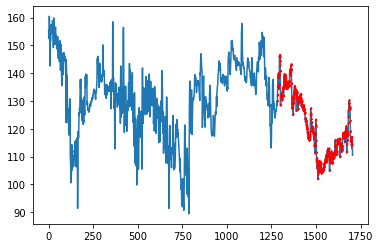

In [14]:


forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)
# inverse transform forecasts and test
forecasts = inverse_transform(series, forecasts, scaler, n_test+2)
actual = [row[n_lag:] for row in test]
actual = inverse_transform(series, actual, scaler, n_test+2)
# evaluate forecasts
evaluate_forecasts(actual, forecasts, n_lag, n_seq)
# plot forecasts
plot_forecasts(series, forecasts, n_test+2)

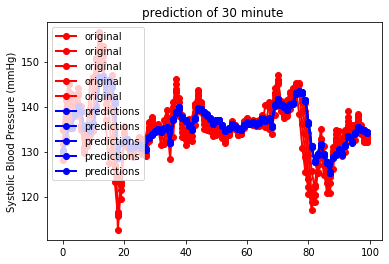

In [15]:
# line plot of observed vs predicted
fig, ax = plt.subplots(1)
ax.plot(actual[:100],'ro-', label='original',linewidth = 2 )
ax.plot(forecasts[:100] ,'bo-', label='predictions',linewidth = 2)
#ax.axvline(x=len(train_scaled)+1,color='k', linestyle='--')
ax.legend(loc='upper left')
ax.set_title('prediction of 30 minute ')
ax.set_ylabel('Systolic Blood Pressure (mmHg)')
plt.show()